In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
q.IBMQ.load_account() # Load account from disk
q.IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bes-qis', project='argonne')>]

In [4]:
provider = q.IBMQ.get_provider(group='bes-qis')
backend = provider.get_backend('ibmq_boeblingen')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
defaults = backend.defaults()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [13]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [6]:
pulse_gate = q.circuit.Gate(name='pulse_gate', num_qubits=20, params=[])
cmd_def.add('pulse_gate', qubits=tuple(range(20)), schedule=q.pulse.Schedule())  # pulse does nothing

In [7]:
qreg = q.QuantumRegister(20)
circ = q.QuantumCircuit(qreg)
_ = circ.append(pulse_gate, tuple(range(20)), [])

In [8]:
basis_gates = backend.configuration().basis_gates

# pulse gate has no direct decomposition into basis gates
# instead, just add 'pulse_gate' to basis_gates, so that transpiler doesn't try to transpile it
basis_gates.append('pulse_gate')  

In [9]:
qpt_circs = q.ignis.verification.tomography.process_tomography_circuits(
    circ, prepared_qubits=[qreg[0], qreg[1]], measured_qubits=[qreg[0], qreg[1]])
qpt_circs = [q.transpile(qpt_circ, backend=backend, basis_gates=basis_gates) for qpt_circ in qpt_circs]

In [10]:
qpt_schedules = [q.schedule(qpt_circ, cmd_def=cmd_def, backend=backend) for qpt_circ in qpt_circs]

In [11]:
jobs = []
for i in range(12):
    job = qiskit.execute(qpt_schedules[12 * i: 12 * i + 12], backend=backend, shots=1000)
    jobs.append(job)
print([job.job_id() for job in jobs])

['5db34e97112ab50018d3bba6', '5db34e9a8fecb200125e6570', '5db34e9d24de69001172027f', '5db34ea0e68f7d0018d30670', '5db34ea3e68f7d0018d30672', '5db34ea6e68f7d0018d30674', '5db34ea91cd1b900189fef11', '5db34eacd691f000113feb00', '5db34eaf1cd1b900189fef13', '5db34eb20c8c440019ac2a30', '5db34eb51cd1b900189fef15', '5db34eb8112ab50018d3bba8']


In [12]:
job_ids = ['5db34e97112ab50018d3bba6', '5db34e9a8fecb200125e6570', '5db34e9d24de69001172027f', '5db34ea0e68f7d0018d30670', '5db34ea3e68f7d0018d30672', '5db34ea6e68f7d0018d30674', '5db34ea91cd1b900189fef11', '5db34eacd691f000113feb00', '5db34eaf1cd1b900189fef13', '5db34eb20c8c440019ac2a30', '5db34eb51cd1b900189fef15', '5db34eb8112ab50018d3bba8']
jobs = [provider.backends.retrieve_job(job_id) for job_id in job_ids]

In [14]:
megajob_result = deepcopy(jobs[0].result())
for i in range(1, 12):
    megajob_result.results.extend(jobs[i].result().results)

In [15]:
qpt_tomo = q.ignis.verification.tomography.ProcessTomographyFitter(megajob_result, qpt_circs)

# Have to do all of the below because of https://github.com/Qiskit/qiskit-ignis/issues/283
def _fitter_data(qpt_tomo, standard_weights, beta):
    """Generate tomography fitter data from a tomography data dictionary.
    Args:
        standard_weights (bool, optional): Apply weights to basis matrix
                        and data based on count probability
                        (default: True)
        beta (float): hedging parameter for 0, 1
        probabilities (default: 0.5)
    Returns:
        tuple: (data, basis_matrix, weights) where `data`
        is a vector of the
        probability values, and `basis_matrix`
        is a matrix of the preparation
        and measurement operator, and `weights`
        is a vector of weights for the
        given probabilities.
    Additional Information
    ----------------------
    standard_weights:
        Weights are calculated from from binomial distribution standard
        deviation
    """
    # Get basis matrix functions
    if qpt_tomo._meas_basis:
        measurement = qpt_tomo._meas_basis.measurement_matrix
    else:
        measurement = None
    if qpt_tomo._prep_basis:
        preparation = qpt_tomo._prep_basis.preparation_matrix
    else:
        preparation = None

    data = []
    basis_blocks = []
    if standard_weights:
        weights = []
    else:
        weights = None

    # Check if input data is state or process tomography data based
    # on the label tuples
    label = next(iter(qpt_tomo._data))
    is_qpt = (isinstance(label, tuple) and len(label) == 2 and
              isinstance(label[0], tuple) and isinstance(label[1], tuple))
    # Generate counts keys for converting to np array
    if is_qpt:
        ctkeys = q.ignis.verification.tomography.data.count_keys(len(label[1]))
    else:
        ctkeys = q.ignis.verification.tomography.data.count_keys(len(label))
    for label, cts in qpt_tomo._data.items():
        cts = q.ignis.verification.tomography.data.marginal_counts(cts, meas_qubits=[0,1])

        # Convert counts dict to numpy array
        if isinstance(cts, dict):
            cts = np.array([cts.get(key, 0) for key in ctkeys])
        # Get probabilities
        shots = np.sum(cts)
        probs = np.array(cts) / shots
        data += list(probs)

        # Compute binomial weights
        if standard_weights is True:
            wts = qpt_tomo._binomial_weights(cts, beta)
            weights += list(wts)

        # Get reconstruction basis operators
        if is_qpt:
            prep_label = label[0]
            meas_label = label[1]
        else:
            prep_label = None
            meas_label = label
        prep_op = qpt_tomo._preparation_op(prep_label, preparation)
        meas_ops = qpt_tomo._measurement_ops(meas_label, measurement)
        block = qpt_tomo._basis_operator_matrix(
            [np.kron(prep_op.T, mop) for mop in meas_ops])
        basis_blocks.append(block)
    return data, np.vstack(basis_blocks), weights


data, basis_matrix, weights = _fitter_data(qpt_tomo, standard_weights=True, beta=0.5)
_, cols = np.shape(basis_matrix)
dim = int(np.sqrt(np.sqrt(cols)))
choi_lstsq = q.quantum_info.operators.Choi(q.ignis.verification.tomography.fitters.lstsq_fit.lstsq_fit(
    data, basis_matrix, weights=weights, trace=dim))

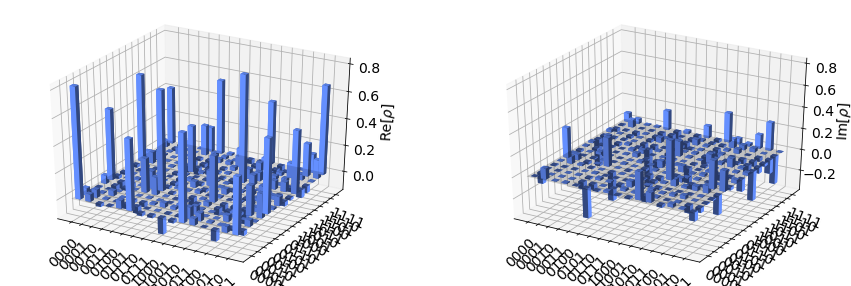

In [16]:
q.tools.visualization.plot_state_city(choi_lstsq.data)

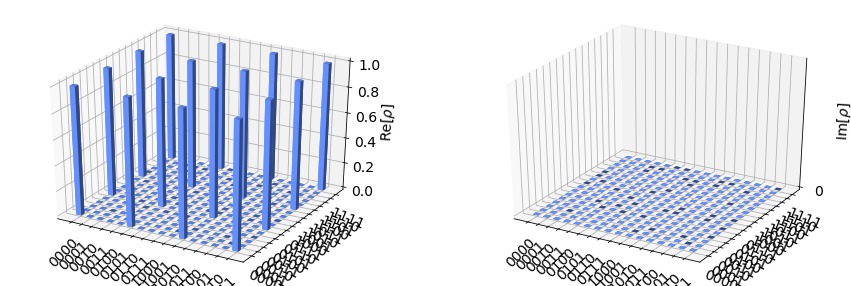

In [17]:
qreg = q.QuantumRegister(2)
circ = q.QuantumCircuit(qreg)

job = qiskit.execute(circ, q.Aer.get_backend('unitary_simulator'))
ideal_unitary = job.result().get_unitary(circ)
choi_ideal = q.tools.qi.qi.outer(ideal_unitary.ravel(order='F'))

q.tools.visualization.plot_state_city(choi_ideal)

In [62]:
print('fit fidelity (process):',
      np.real(q.quantum_info.process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))

fit fidelity (process): 0.3549193837897329
